# 02 — Neural Data Statistics

Overview of raw spike data properties: per-recording summary statistics, example rasters, and angular-position tuning curve quality.

In [1]:
from remapping.dataset import (
    MiceDataset, Animals, GROUP_ORDER, SESSION_ORDER,
    SESSION_TYPE_MAP, EXPERIMENT_TYPE_ORDER, EXPERIMENT_TYPE_COLORS,
)
from remapping.plotting import PlotStyle, get_figures_path
from remapping.processing import smooth_tuning_curves_circularly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

mice = MiceDataset()
style = PlotStyle()
palette = mice.get_group_palette()

fig_path = get_figures_path("0.data_overview", "02_neural_data_statistics")

## Parameters

In [2]:
# Processing parameters (matching the standard pipeline)
ONLY_MOVING = True
BINS_COMPRESS = 3        # temporal binning factor (30.9 Hz → ~10.3 Hz)
BINS_SMOOTHING = 3       # Gaussian σ for firing rate smoothing
BINS_PHI = 360           # angular bins for tuning curves
TC_SMOOTH_KERNEL = 20    # circular smoothing kernel for tuning curves

# Example subject for raster plot
EXAMPLE_SUBJECT = Animals.M62

# Timing
FS_ORIGINAL = 30.9                         # original sampling rate (Hz)
FS_BINNED = FS_ORIGINAL / BINS_COMPRESS    # ~10.3 Hz after binning
BIN_DURATION_MS = 1000.0 / FS_BINNED      # ~97 ms per bin

## 1. Per-recording spike statistics

Summary table with one row per recording (subject × FOV × session × run). For each recording we report: number of neurons, duration, mean spike rate across neurons, fraction of active neurons, and peak spike amplitude.

In [3]:
recording_stats = []

for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                spikes_b, phi_b, time_b, (cell_ids, _) = mice.load_spikes_binned(
                    subject, fov, session, run,
                    only_moving=ONLY_MOVING, bins_compress=BINS_COMPRESS,
                )
                n_neurons = spikes_b.shape[1]
                n_bins = spikes_b.shape[0]
                duration_s = n_bins / FS_BINNED

                # Mean spike rate per neuron (Hz): mean spikes per bin × bins per second
                mean_rate_hz = spikes_b.mean(axis=0) * FS_BINNED  # (N,)
                # Fraction of time bins where each neuron is active
                frac_active = (spikes_b > 0).mean(axis=0)  # (N,)

                recording_stats.append({
                    "Subject": subject.value,
                    "Group": group,
                    "FOV": fov,
                    "Session": session,
                    "Run": run,
                    "N neurons": n_neurons,
                    "Duration (s)": round(duration_s, 1),
                    "Mean rate (Hz)": round(mean_rate_hz.mean(), 3),
                    "Std rate (Hz)": round(mean_rate_hz.std(), 3),
                    "Mean frac active": round(frac_active.mean(), 3),
                    "Max spike amp": round(spikes_b.max(), 2),
                })

df_rec = pd.DataFrame(recording_stats)
print(f"Total recordings: {len(df_rec)}")
df_rec

Total recordings: 321


,Subject,Group,FOV,Session,Run,N neurons,Duration (s),Mean rate (Hz),Std rate (Hz),Mean frac active,Max spike amp
0,m62,WT_old,2,fam1fam2,fam1,292,458.2,0.530,0.427,0.016,40.87
1,m62,WT_old,2,fam1fam2,fam2,292,429.5,0.431,0.418,0.014,26.47
2,m62,WT_old,2,fam1nov,fam1,247,777.1,0.439,0.352,0.013,31.49
3,m62,WT_old,2,fam1nov,nov,247,543.2,0.276,0.374,0.008,34.43
4,m62,WT_old,2,fam1fam1rev,fam1,232,682.1,0.365,0.401,0.011,30.97
...,...,...,...,...,...,...,...,...,...,...,...
316,m132,5xFAD_young,2,fam1novfam1,nov,167,910.1,0.177,0.098,0.008,11.09
317,m132,5xFAD_young,2,fam1novfam1,fam1r2,167,495.0,0.218,0.123,0.008,13.58
318,m132,5xFAD_young,2,fam1fam1revfam1,fam1,188,554.5,0.244,0.146,0.008,14.13
319,m132,5xFAD_young,2,fam1fam1revfam1,fam1rev,188,648.8,0.242,0.117,0.009,12.74


## 2. Example raster plot

Raw spike raster for an example subject, showing 20 neurons over the first 60 seconds as a heatmap. Pixel intensity encodes spike amplitude.

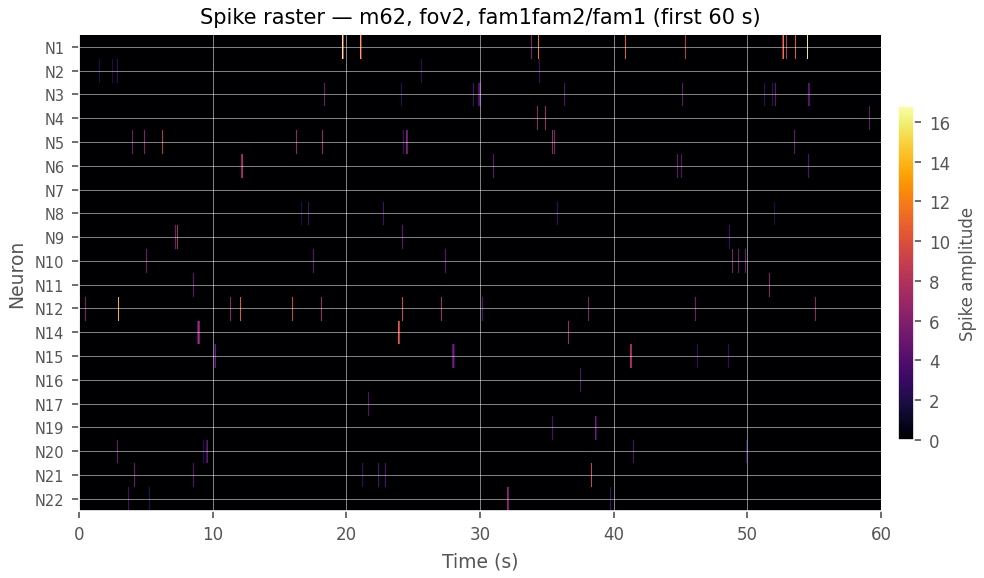

In [4]:
# Pick first available recording for the example subject
ex_fov = mice.get_available_fovs(EXAMPLE_SUBJECT)[0]
ex_sess = mice.get_available_sessions(EXAMPLE_SUBJECT, ex_fov)[0]
ex_run = mice.get_available_runs(EXAMPLE_SUBJECT, ex_fov, ex_sess)[0]

df_raw = mice.load_data(EXAMPLE_SUBJECT, ex_fov, ex_sess, ex_run)
cell_cols = [c for c in df_raw.columns if c.isdigit()]
time_s = df_raw["glob_time"].values - df_raw["glob_time"].values[0]

# Select first 60 seconds and 20 neurons
t_max = 60  # seconds
mask_t = time_s <= t_max
n_show = min(20, len(cell_cols))
sel_cells = cell_cols[:n_show]

spikes_raw = df_raw.loc[mask_t, sel_cells].values.T  # (n_show, T)
time_show = time_s[mask_t]

fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 4))
im = ax.imshow(
    spikes_raw, aspect="auto", interpolation="none",
    cmap="inferno", vmin=0,
    extent=[time_show[0], time_show[-1], n_show - 0.5, -0.5],
)
ax.grid(
    True, which="major",
    color="white",
    linewidth=0.3,   # thinner than default
    alpha=0.8
)
ax.set_yticks(range(n_show))
ax.set_yticklabels([f"N{c}" for c in sel_cells], fontsize=7)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron")
ax.set_title(f"Spike raster — {EXAMPLE_SUBJECT.value}, fov{ex_fov}, {ex_sess}/{ex_run} (first {t_max} s)")

cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
cbar.set_label("Spike amplitude", fontsize=8)

plt.tight_layout()
fig.savefig(fig_path / "example_raster.pdf")
plt.show()

## 3. Tuning curve selectivity (angular-position tuning)

For each neuron, compute a selectivity index from its angular-position tuning curve: the ratio of peak to mean activity. High values indicate strong spatial tuning. We compare distributions across genotype × age groups.

In [5]:
# Compute selectivity index per neuron from angular-position tuning curves
selectivity_rows = []

for subject in mice.get_all_subjects():
    info = mice.get_subject_info(subject)
    group = f"{info['genotype']}_{info['age']}"
    for fov in mice.get_available_fovs(subject):
        for session in mice.get_available_sessions(subject, fov):
            for run in mice.get_available_runs(subject, fov, session):
                fr, phi_b, _, (cell_ids, _), tc, phi_bins = (
                    mice.load_all_data_from_spikes_binned_smoothed(
                        subject, fov, session, run,
                        only_moving=ONLY_MOVING,
                        bins_compress=BINS_COMPRESS,
                        bins_smoothing=BINS_SMOOTHING,
                        bins_phi=BINS_PHI,
                    )
                )
                tc_smooth = smooth_tuning_curves_circularly(tc, TC_SMOOTH_KERNEL)

                for j in range(tc_smooth.shape[1]):
                    curve = tc_smooth[:, j]
                    mean_val = np.nanmean(curve)
                    peak_val = np.nanmax(curve)
                    selectivity = peak_val / mean_val if mean_val > 0 else 0.0
                    selectivity_rows.append({
                        "Subject": subject.value,
                        "Group": group,
                        "Session": session,
                        "Run": run,
                        "Neuron": cell_ids[j],
                        "selectivity": selectivity,
                        "peak": peak_val,
                        "mean_tc": mean_val,
                    })

df_sel = pd.DataFrame(selectivity_rows)
print(f"Neurons with tuning curves: {len(df_sel):,}")
df_sel.describe()

Neurons with tuning curves: 63,924


,selectivity,peak,mean_tc
count,63924.000000,63924.000000,63924.000000
mean,2.797288,0.125458,0.053999
std,1.874227,0.099692,0.043611
min,0.000000,0.000000,0.000000
25%,1.857528,0.060592,0.023552
50%,2.313243,0.096548,0.044254
75%,3.097950,0.160559,0.072107
max,18.000000,0.929354,0.462667


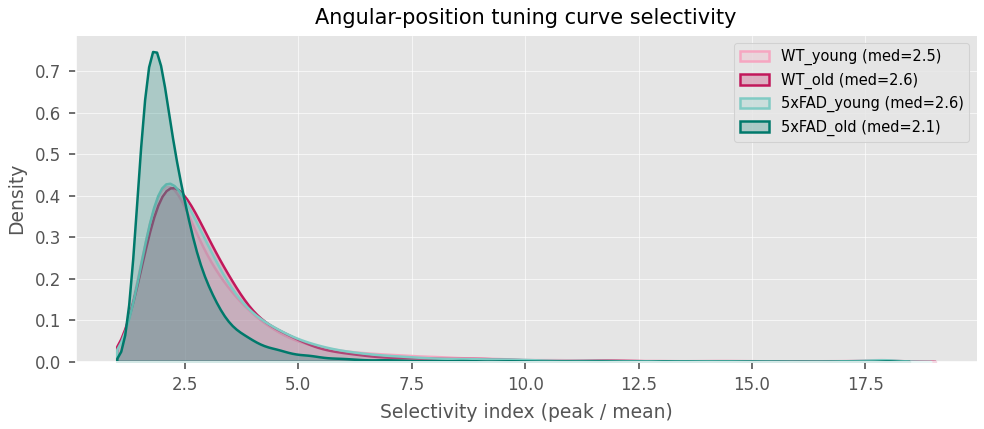

In [6]:
fig, ax = plt.subplots(figsize=(PlotStyle.FULL_WIDTH, 3))

for group in GROUP_ORDER:
    subset = df_sel.loc[df_sel["Group"] == group, "selectivity"]
    sns.kdeplot(
        subset, ax=ax, color=palette[group], fill=True, alpha=0.25,
        linewidth=1.2, clip=(1, None), label=f"{group} (med={subset.median():.1f})",
    )

ax.set_xlabel("Selectivity index (peak / mean)")
ax.set_ylabel("Density")
ax.set_title("Angular-position tuning curve selectivity")
ax.legend(fontsize=7)
plt.tight_layout()
fig.savefig(fig_path / "tuning_selectivity.pdf")
plt.show()